<a href="https://colab.research.google.com/github/nedokormysh/Data_Fusion_Contest_2022/blob/main/ML_in_business_course_work_step_1_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

**Стандартная версия**
Нужно реализовать rest api на базе flask в google colab.

1. выбрать себе датасет (который интересен или нравится больше всего, можно глянуть здесь https://economic-caper-a4c.notion.site/d062c410b90145bca90fc23b1348c813), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
2. Реализовать ноутбук с сервером
3. Реализовать ноутбук с клиентом


**Сложная версия**

Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

1. выбрать себе датасет (который интересен или нравится больше всего, можно глянуть здесь https://economic-caper-a4c.notion.site/d062c410b90145bca90fc23b1348c813), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
2. для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта)
3. итоговый проект должен содержать:
    1. каталог app/models/ (здесь модель-пайплайн предобученная либо код обучения модели-пайплайна)
    2. файл app/run_server.py (здесь основной код flask-приложения)
    3. requirements.txt (список пакетов, которые у вас используются в проекте - в корне проекта)
    4. README.md (здесь какое-то описание, что вы делаете, что за данные, как запускать и т.д)
    5. *Dockerfile
    6. *docker-entrypoint.sh
4. *front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

Возьмём датасет https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

!pip install catboost -q

from catboost import CatBoostClassifier
import xgboost as xgb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.8 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nedokormysh/GB_ML_business/course_project/aug_train.csv', index_col='enrollee_id')
df.sort_index().head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
1,city_103,0.920,Male,No relevent experience,no_enrollment,High School,NaN,2,NaN,Pvt Ltd,never,150,0.0
2,city_103,0.920,Male,No relevent experience,no_enrollment,Phd,STEM,15,10000+,NGO,3,128,1.0
4,city_103,0.920,Male,No relevent experience,no_enrollment,Masters,STEM,9,50-99,Public Sector,>4,13,0.0
5,city_67,0.855,Male,Has relevent experience,no_enrollment,Masters,STEM,10,<10,Early Stage Startup,1,12,0.0
7,city_136,0.897,Male,Has relevent experience,Full time course,Masters,STEM,13,NaN,NaN,1,18,0.0


In [3]:
df.shape

(19158, 13)

In [4]:
X = df.iloc[:,:-1]
y = df['target']

In [5]:
y.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [19]:
def save(df, PATH):
    df.to_csv(PATH, index=False, encoding='utf-8', sep=';')

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                    y, test_size=0.33, random_state=7575)

#save test
X_val.to_csv("X_test.csv", index=None)
y_val.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

Text(0.5, 1.0, 'target')

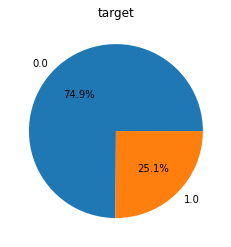

In [7]:
labels = y_train.value_counts().index
sizes = y_train.value_counts().values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('target')

In [8]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Количество наблюдений в обучающей выборке: {y_train.count()}',
      f'Количество наблюдений в тестовой выборке: {y_val.count()}',
      f'Дисбаланс целевой переменной: {disbalance:.2f}', sep='\n')

Количество наблюдений в обучающей выборке: 12835
Количество наблюдений в тестовой выборке: 6323
Дисбаланс целевой переменной: 2.99


Рассмотрим чуть подробнее обучающую выборку.

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12835 entries, 948 to 20699
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    12835 non-null  object 
 1   city_development_index  12835 non-null  float64
 2   gender                  9841 non-null   object 
 3   relevent_experience     12835 non-null  object 
 4   enrolled_university     12585 non-null  object 
 5   education_level         12521 non-null  object 
 6   major_discipline        10923 non-null  object 
 7   experience              12803 non-null  object 
 8   company_size            8857 non-null   object 
 9   company_type            8708 non-null   object 
 10  last_new_job            12554 non-null  object 
 11  training_hours          12835 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 1.3+ MB


У нас есть пропущенные значения. Посмотрим какой процент пропусков от общего количества объектов.

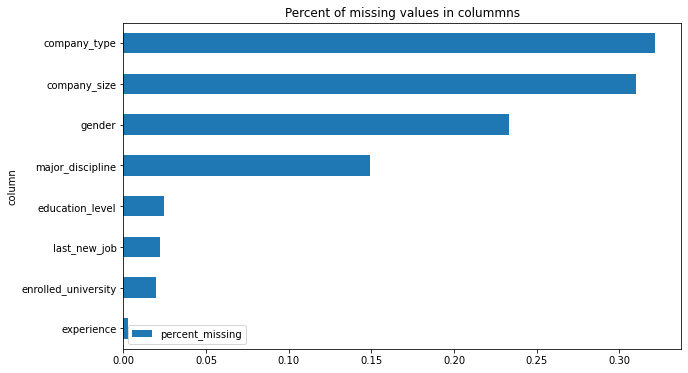

In [10]:
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (10, 6)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');

plot_missing_values(X_train)

Начнём создавать пайплайн для обработки 

In [11]:
cat_cols = [
    'city', 
            'gender', 'relevent_experience',
            'enrolled_university', 'education_level', 'major_discipline',
            'experience', 'company_size', 'company_type', 'last_new_job',]
cont_columns = ['city_development_index', 'training_hours']

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):        
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

class NaFiller(BaseEstimator, TransformerMixin):
    def __init__(self, key, mthd):
        self.key = key
        self.mthd = mthd        

    def fit(self, X, y=None):
        self.modes = X.mode()
        # self.medians = X.median()
        return self

    def transform(self, X):
        if self.mthd == 'Other':
          X[self.key].fillna('Other', inplace=True)
        # elif self.mthd == 'Median':
        #   X[self.key].fillna(self.medians[self.key], inplace=True)
        elif self.mthd == 'Mode':
          X[self.key].fillna(self.modes[self.key][0], inplace=True)  
        return X

In [ ]:
from sklearn.linear_model import LogisticRegression

In [13]:
X = df.iloc[:,:-1]
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=7575)

cat_cols = [
            'city', 
            'gender', 'relevent_experience',
            'enrolled_university', 'education_level', 'major_discipline',
            'experience', 'company_size', 'company_type', 'last_new_job',]

cont_columns = ['city_development_index', 'training_hours']

# 1
city = Pipeline([
                ('selector', FeatureSelector(column='city')),
                ('ohe', OHEEncoder(key='city'))
                 ])
# 2
city_development_index = Pipeline([
                ('selector', NumberSelector(key='city_development_index')),
                ('scaler', StandardScaler())
                ])
#3
gender =  Pipeline([                 
                   ('fill', NaFiller(key='gender', mthd='Other')),
                   ('selector', FeatureSelector(column='gender')),
                   ('ohe', OHEEncoder(key='gender'))
                   ])
# 4
enrolled_university =  Pipeline([                 
                ('fill', NaFiller(key='enrolled_university', mthd='Mode')),
                ('selector', FeatureSelector(column='enrolled_university')),
                ('ohe', OHEEncoder(key='enrolled_university'))
                ])
# 5
education_level = Pipeline([                 
                ('fill', NaFiller(key='education_level', mthd='Mode')),
                ('selector', FeatureSelector(column='education_level')),
                ('ohe', OHEEncoder(key='education_level'))
                ])
# 6
major_discipline = Pipeline([                 
                ('fill', NaFiller(key='major_discipline', mthd='Mode')),
                ('selector', FeatureSelector(column='major_discipline')),
                ('ohe', OHEEncoder(key='major_discipline'))
                ])
# 7
experience = Pipeline([                 
                ('fill', NaFiller(key='experience', mthd='Other')),
                ('selector', FeatureSelector(column='experience')),
                ('ohe', OHEEncoder(key='experience'))
            ])
# 8
company_size =  Pipeline([                 
                ('fill', NaFiller(key='company_size', mthd='Other')),
                ('selector', FeatureSelector(column='company_size')),
                ('ohe', OHEEncoder(key='company_size'))
            ])
# 9
company_type =  Pipeline([                 
                ('fill', NaFiller(key='company_type', mthd='Other')),
                ('selector', FeatureSelector(column='company_type')),
                ('ohe', OHEEncoder(key='company_type'))
            ])
# 10
last_new_job = Pipeline([                 
                ('fill', NaFiller(key='last_new_job', mthd='Mode')),
                ('selector', FeatureSelector(column='last_new_job')),
                ('ohe', OHEEncoder(key='last_new_job'))
            ])

# 11

training_hours = Pipeline([
                ('selector', NumberSelector(key='training_hours')),
                ('scaler', StandardScaler())
                ])

feats = FeatureUnion([
                      ('city', city),
                      ('city_development_index', city_development_index),
                      ('gender', gender),
                      ('enrolled_university', enrolled_university),
                      ('education_level', education_level),
                      ('major_discipline', major_discipline),
                      ('experience', experience),
                      ('company_size', company_size),
                      ('company_type', company_type),
                      ('last_new_job', last_new_job),
                      ('training_hours', training_hours),
                      ])

In [14]:
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit(X_train)

feature_processing.transform(X_train)
feature_processing.transform(X_val)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.98900213],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -0.17426574],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.1410112 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  2.33645253],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.88923849],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.49018394]])

In [ ]:
# classifier = Pipeline([
#     ('features', feats),
#     ('classifier', CatBoostClassifier(random_state=7575, verbose=False)),
# ])
# classifier.fit(X_train, y_train)
# # 
# # feature_processing.fit_transform(X_train)
# y_score = classifier.predict_proba(X_val)[:, 1]
# print("model score: %.3f" % classifier.score(X_val, y_val))

model score: 0.791


In [15]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state=7575, verbose=False)),
])
# classifier.fit(X_train, y_train)

# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
# y_score = classifier.predict_proba(X_val)[:, 1]

CV score is 0.7958480699476426+-0.007722732638905003


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('city_development_index',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='city_development_index')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('gender',
                                                 Pipeline(steps=[('fill',
       

In [16]:
classifier.steps

[('features', FeatureUnion(transformer_list=[('city',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='city')),
                                                  ('ohe',
                                                   OHEEncoder(key='city'))])),
                                 ('city_development_index',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='city_development_index')),
                                                  ('scaler', StandardScaler())])),
                                 ('gender',
                                  Pipeline(steps=[('fill',
                                                   NaFiller(key='gender',
                                                            mthd='Other')),
                                                  ('selector',
                                          

In [18]:
import dill

with open("./models/xgb_simple.dill", "wb") as f:
    dill.dump(classifier, f)